# Predict License Plate Number
Version 3
- 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import os 
import cv2
import shutil
from tqdm.notebook import tqdm
from glob import glob
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.models import load_model, Sequential
from keras.callbacks import ModelCheckpoint


# Function to extract license plate number from image file name for verifying the predicted number. 

In [3]:
### Extract license plate text from image for verifying the predicted text

# Chinese EV license plate consists of eight characters:
# province (1 character), alphabets (1 character), alphabets/digits (6 characters).
# "0_0_22_27_27_33_16_20" is the index of each character.
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
             "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤",
             "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁",
             "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
             'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', 'O']

def extract_license_plate_text(filename):

    fname = os.path.basename(filename)
    iname = fname.split('-')

    # Extract license plate number text
    txt = iname[4].split('_')
    label = [provinces[int(txt[0])], alphabets[int(txt[1])]]
    for idx in range(2,8):
        label.append(ads[int(txt[idx])])
    LP_text = ''.join(label)

    return LP_text

# Load detector model and recognition model

Best detector and recognition models are stored during training by the callback function.

These models have the lowest validation loss during the training.

In [4]:
# Load detector model
#detector = load_model('gdrive/MyDrive/Model/license_plate_detector_best_model.h5', custom_objects={'iou_loss': iou_loss, 'iou_metric': iou_metric})
detector = load_model('gdrive/MyDrive/Model/license_plate_detector_best_model.h5', compile=False)

# Load recogniser model
recogniser = load_model('gdrive/MyDrive/Model/license_plate_recogniser_best_model.h5', compile=False)


In [5]:
# Total number of our output classes: len(char_list) = 67
char_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
             'W', 'X', 'Y', 'Z',
             "皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
             "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤",
             "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁",
             "新", "警", "学"]


# Load one image at a time to predict its license plate number

Total number of test images are 1,000

Only display the first 20 images with their predicted license plate numbers.

Total images =  1000
Correct prediction =  897
Prediction Accuracy =  89.70%


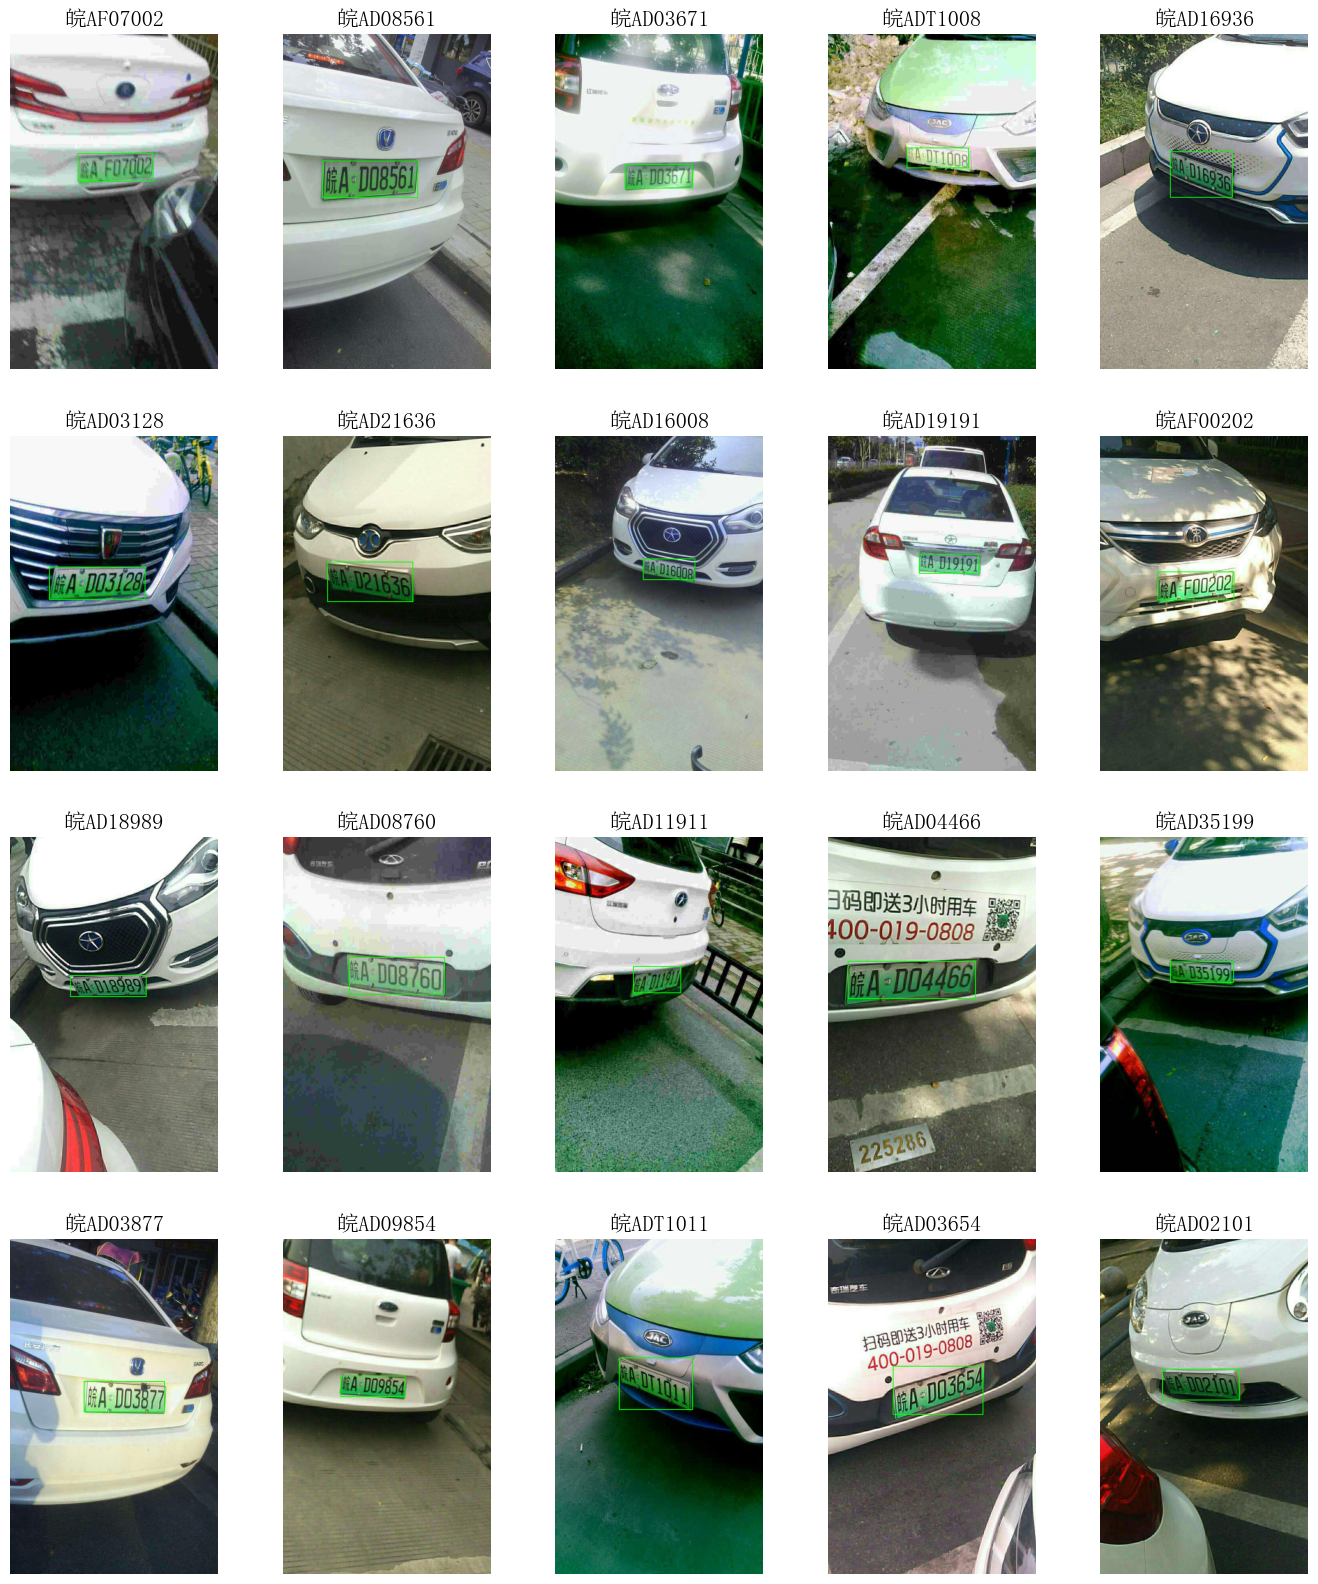

In [6]:
# Data preprocessing

path = glob("gdrive/MyDrive/Dataset/CCPD2020/ccpd_green/test/*.jpg")

NUM_IMAGES = 1000
count = 0
hit_target = 0

plt.figure(figsize=(17,20))  #figsize = (width, height) in inches

# Set font properties to include Chinese font for matplotlib
font = FontProperties(fname=r"gdrive/MyDrive/Font/simsun.ttc", size=16)

for filename in path:
    ### Load input image and convert it from BGR to RGB format
    input_img = cv2.imread(filename)
    # img.shape returns (Height, Width, Number of Channels)
    h,w,d = input_img.shape
    # cv2.imread read image as BGR, so need to convert to RGB
    input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)

    # cv2.resize(img, (width, height))
    img224 = cv2.resize(input_img,(224,224))

    # Convert image to numpy array 
    image224 = np.array(img224,dtype=np.float32).reshape(1,224,224,3)

    # Normalise image value
    nimage224 = image224 / 255.

    # Predict the bounding box
    bbox = detector.predict(x = nimage224, verbose = 0)

    # Un-normalised bounding box co-ordinates
    xmin = int(bbox[0][0] * w)
    ymin = int(bbox[0][1] * h)
    xmax = int(bbox[0][2] * w)
    ymax = int(bbox[0][3] * h)

    # Crop license plate from input image using predicted bounding box
    img_grayscale = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    cropped_image = img_grayscale[ymin:ymax, xmin:xmax]

    # Convert cropped image into numpy array, and resize to (1,32(h),128(w),1)
    lpimg = cv2.resize(cropped_image,(128,32))  # cv2.resize(img, (width, height))
    #lpimg = lpimg[..., np.newaxis]  # add one axis to (128,32) and become (128,32,1)
                                    # can also use this, #lpimg = lpimg[:, :, np.newaxis]
  
    # Convert image to numpy array and normalise
    lp_image = np.array(lpimg, dtype=np.float32)
    #print("nlp_image shape, before reshape = ", lp_image.shape)
    nlp_image = lp_image/255.
    nlp_image = nlp_image.reshape(1,32,128,1)
    #print("nlp_image shape = ", nlp_image.shape)

    # Predict the license plate number
    predicted_text = recogniser.predict(x = nlp_image, verbose = 0)
    #predicted_text = recogniser.predict(nlp_image)
    #print("predicted text shape = ", predicted_text.shape)
    #print("predicted text = ", predicted_text)

    # Use CTC decoder
    out = K.get_value(K.ctc_decode(predicted_text, input_length=np.ones(predicted_text.shape[0])*predicted_text.shape[1],
                         greedy=True)[0][0])
    #print("output shape = ", out.shape)
    #print("output = ", out)
 
    # Decode predicted license plate text, from index to character
    pred_txt = ""
    for x in out:
        for p in x:
            if int(p) != -1:
                pred_txt += char_list[int(p)]

    target_txt = extract_license_plate_text(filename)
    if (pred_txt == target_txt):
        hit_target += 1

    # Draw bounding box on input image
    # Only display first 20 images
    if (count < 20):
        image = cv2.rectangle(input_img,(xmin,ymin),(xmax,ymax),color=(0, 255, 0),thickness=2)
        plt.subplot(4,5,count+1)  # (row, column, index=1,2,3,...,row*column)
        plt.axis('off')
        plt.title(pred_txt, fontproperties=font)
        plt.imshow(image)

    count += 1
    if (count == NUM_IMAGES):
        break

print("Total images = ", count)
print("Correct prediction = ", hit_target)
print("Prediction Accuracy = ", "{:.2%}".format(hit_target/count))
